In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
!pip install -q kaggle
from google.colab import files

# Upload your Kaggle API key (kaggle.json) file
files.upload()

# Move the uploaded file to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sid321axn/malicious-urls-dataset

 30% 5.00M/16.9M [00:00<00:00, 40.9MB/s]
100% 16.9M/16.9M [00:00<00:00, 84.0MB/s]


In [ ]:
!unzip malicious-urls-dataset.zip

Archive:  malicious-urls-dataset.zip
replace malicious_phish.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

malicious_phish.csv  malicious-urls-dataset.zip  sample_data


In [ ]:
df=pd.read_csv('malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement

**Noise Detection**

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest

X = df[['url']]

# Convert URLs to TF-IDF features or other appropriate representation
# For simplicity, we'll use a basic count vectorizer here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X['url'])

# Use Isolation Forest to detect outliers
clf = IsolationForest(contamination=0.05)  # Adjust the contamination parameter as needed
clf.fit(X_count)

# Predict outliers in the dataset
outliers = clf.predict(X_count)

# Add a new column 'is_outlier' to the dataframe indicating whether each URL is an outlier
df['is_outlier'] = (outliers == -1)

# Display the URLs identified as outliers
print("Malicious URLs identified as outliers:")
print(df[df['is_outlier']]['url'])


Malicious URLs identified as outliers:
50        http://www.newtec.ac.uk/courses/health-and-soc...
61        http://www.shaborooz.ir/index.php?view=article...
91        http://fanpage.gr/family/gineka/%ce%b1%cf%85%c...
115       http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...
120       international.uiowa.edu/services/language/alln...
                                ...                        
639867                tc.eserver.org/dir/Content-Management
640508             www.edu.uni-klu.ac.at/~mkropfbe/kde.html
645334    www.drobe.co.uk/archives/?directory=/ftp.uni-s...
647507             psychology.utoledo.edu/default.asp?id=99
649931           games.groups.yahoo.com/group/uk-wraith-st/
Name: url, Length: 32523, dtype: object


**Noise Removel**

In [ ]:
# Load the CSV file
df = pd.read_csv('malicious_phish.csv')

X = df[['url']]

# Convert URLs to TF-IDF features or other appropriate representation
# For simplicity, we'll use a basic count vectorizer here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X['url'])

# Use Isolation Forest to detect outliers
clf = IsolationForest(contamination=0.05)  # Adjust the contamination parameter as needed
clf.fit(X_count)

# Predict outliers in the dataset
outliers = clf.predict(X_count)

# Add a new column 'is_outlier' to the dataframe indicating whether each URL is an outlier
df['is_outlier'] = (outliers == -1)

# Display the URLs identified as outliers
print("Malicious URLs identified as outliers:")
print(df[df['is_outlier']]['url'])

# Remove outliers from the dataframe
df_no_noise = df[df['is_outlier'] == False]

# Display the cleaned dataframe without outliers
print("\nDataFrame after removing outliers:")
print(df_no_noise)


Malicious URLs identified as outliers:
3         http://www.garage-pirenne.be/index.php?option=...
61        http://www.shaborooz.ir/index.php?view=article...
84        chacha.com/question/who-said-the-quote-%27say-...
91        http://fanpage.gr/family/gineka/%ce%b1%cf%85%c...
115       http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...
                                ...                        
643483     www.orangevalley.co.uk/search_engine/search.html
643917                                 www.ctan.org/search/
644609    www.cleveland.com/search/index.ssf?/base/busin...
645631                     www.search-cumbria.com/total.htm
649627    grognardia.blogspot.com/2011/02/complete-histo...
Name: url, Length: 32445, dtype: object

DataFrame after removing outliers:
                                                      url        type  \
0                                        br-icloud.com.br    phishing   
1                     mp3raid.com/music/krizz_kaliko.html      benign   
2     

In [ ]:
pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 2.7 MB/s eta 0:00:00


**Feature Extraction**

In [ ]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

#pip install googlesearch-python

from googlesearch import search

def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):

    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count-letters']= df['url'].apply(lambda i: letter_count(i))

# pip install tld

from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [ ]:
print(df.shape)
df.head()

(651191, 26)


url        type  is_outlier  \
0                                   br-icloud.com.br    phishing       False   
1                mp3raid.com/music/krizz_kaliko.html      benign       False   
2                    bopsecrets.org/rexroth/cr/1.htm      benign       False   
3  http://www.garage-pirenne.be/index.php?option=...  defacement        True   
4  http://adventure-nicaragua.net/index.php?optio...  defacement       False   

   use_of_ip  abnormal_url  google_index  count.  count-www  count@  \
0          0             0             1       2          0       0   
1          0             0             1       2          0       0   
2          0             0             1       2          0       0   
3          0             1             1       3          1       0   
4          0             1             1       2          0       0   

   count_dir  ...  count-  count=  url_length  hostname_length  sus_url  \
0          0  ...       1       0          16                0        0   
1          2  ...       0       0          35                0        0   
2          3  ...       0       0          31                0        0   
3          1  ...       1       4          88               21        0   
4          1  ...       1       3         235               23        0   

   count-digits  count-letters  fd_length   tld  tld_length  
0             0             13          0  None          -1  
1             1             29          5  None          -1  
2             1             25          7  None          -1  
3             7             63          9    be           2  
4            22            199          9   net           3  

[5 rows x 26 columns]

**One Hot Encoder**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'type' is the column you want to one-hot encode
df = pd.read_csv("malicious_phish.csv")  # Make sure to replace this with the correct file path

# Converting type of columns to category
df['type'] = df['type'].astype('category')

# Create an instance of One-hot-encoder
enc = OneHotEncoder(sparse=False, drop='first')

# Reshape the 'type' column and apply one-hot encoding
encoded_data = enc.fit_transform(df[['type']])

# Create new column names for the one-hot encoded columns
new_columns = [f"{col}_encoded" for col in df['type'].cat.categories[1:]]

# Create a DataFrame with the encoded data and new column names
encoded_df = pd.DataFrame(encoded_data, columns=new_columns)

# Concatenate the original DataFrame and the one-hot encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop the original 'type' column
#df.drop(['type'], axis=1, inplace=True)

print(df)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


                                                      url        type  \
0                                        br-icloud.com.br    phishing   
1                     mp3raid.com/music/krizz_kaliko.html      benign   
2                         bopsecrets.org/rexroth/cr/1.htm      benign   
3       http://www.garage-pirenne.be/index.php?option=...  defacement   
4       http://adventure-nicaragua.net/index.php?optio...  defacement   
...                                                   ...         ...   
651186            xbox360.ign.com/objects/850/850402.html    phishing   
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing   
651188         www.gamespot.com/xbox360/action/deadspace/    phishing   
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing   
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing   

        defacement_encoded  malware_encoded  phishing_encoded  
0                      0.0              0.0               1

**SMOTE ALGORITHM**

Accuracy: 0.8533158270564116


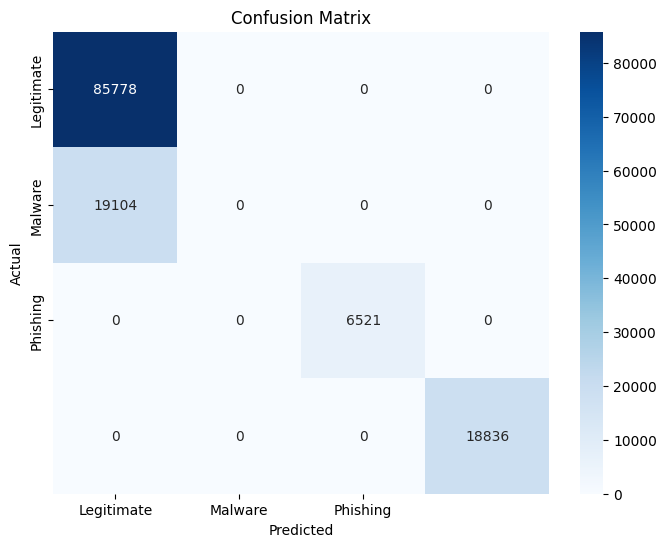

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      benign       0.82      1.00      0.90     85778
  defacement       0.00      0.00      0.00     19104
     malware       1.00      1.00      1.00      6521
    phishing       1.00      1.00      1.00     18836

    accuracy                           0.85    130239
   macro avg       0.70      0.75      0.72    130239
weighted avg       0.73      0.85      0.79    130239



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Replace with your chosen classifier
from sklearn.metrics import accuracy_score

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded' ]]

# Target Variable
y = df['type']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the SMOTE object
sm = SMOTE(random_state=42)

# Oversample the minority class
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Instantiate Logistic Regression as an example
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train_resampled, y_train_resampled)

# Evaluate the classifier
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the classifier
y_pred = classifier.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Legitimate', 'Malware', 'Phishing'], yticklabels=['Legitimate', 'Malware', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


**Linear Regression**

Mean Squared Error: 0.11996979287238946
R-squared: 0.8987805207911381


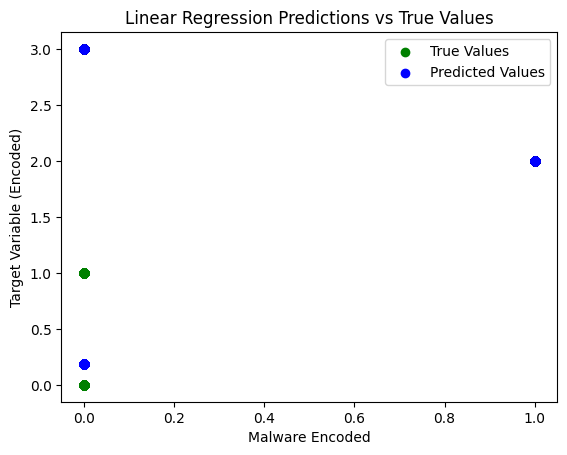

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Split the dataset into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate Linear Regression
regressor = LinearRegression()

# Train the regressor
regressor.fit(X_train_reg, y_train_reg)

# Predict using the trained regressor
y_pred_reg = regressor.predict(X_test_reg)

# Evaluate the regressor
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize linear regression predictions
plt.scatter(X_test_reg['malware_encoded'], y_test_reg, color='green', label='True Values')
plt.scatter(X_test_reg['malware_encoded'], y_pred_reg, color='blue', label='Predicted Values')
plt.xlabel("Malware Encoded")  # Adjust this label based on your actual predictor variables
plt.ylabel("Target Variable (Encoded)")
plt.title("Linear Regression Predictions vs True Values")
plt.legend()
plt.show()


**Logistic Regression**

Logistic Regression Accuracy: 0.8533158270564116


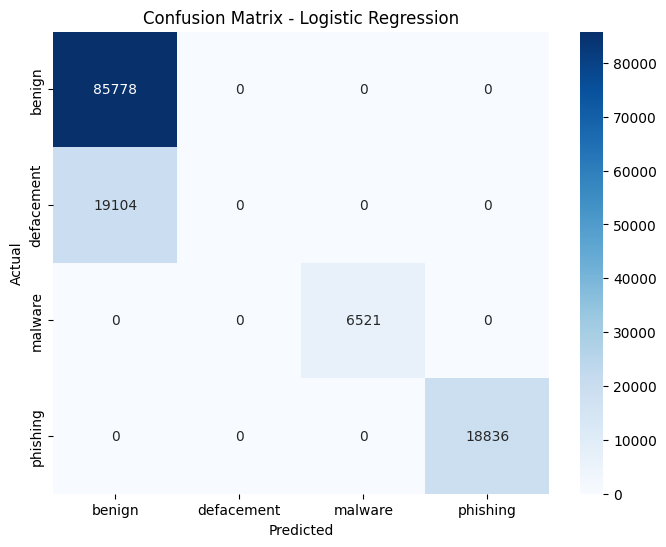

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate Logistic Regression
logreg_classifier = LogisticRegression()

# Train the Logistic Regression model
logreg_classifier.fit(X_train, y_train)

# Predict using the trained Logistic Regression model
y_pred_logreg = logreg_classifier.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Logistic Regression Accuracy:", accuracy_logreg)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


**Lasso Regression**

Mean Squared Error: 0.6002401928530006
R-squared: 0.4935725213309904


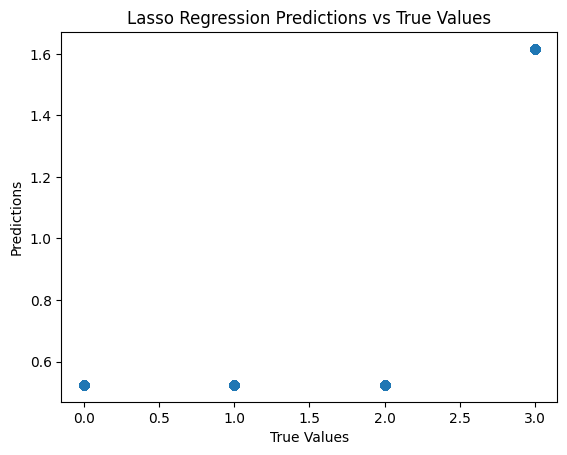

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'type_encoded' is a numeric target variable
y_reg = df['type_encoded']

# Split the dataset into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Instantiate Lasso Regression with a specific alpha value
lasso_reg = Lasso(alpha=0.2)  # You can adjust the alpha value

# Train the Lasso Regression model
lasso_reg.fit(X_train_reg, y_train_reg)

# Predict using the trained model
y_pred_reg = lasso_reg.predict(X_test_reg)

# Evaluate the model
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize Lasso Regression predictions
plt.scatter(y_test_reg, y_pred_reg)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Lasso Regression Predictions vs True Values")
plt.show()


**K-Means with KNN**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KNN Classifier Accuracy: 0.8533158270564116


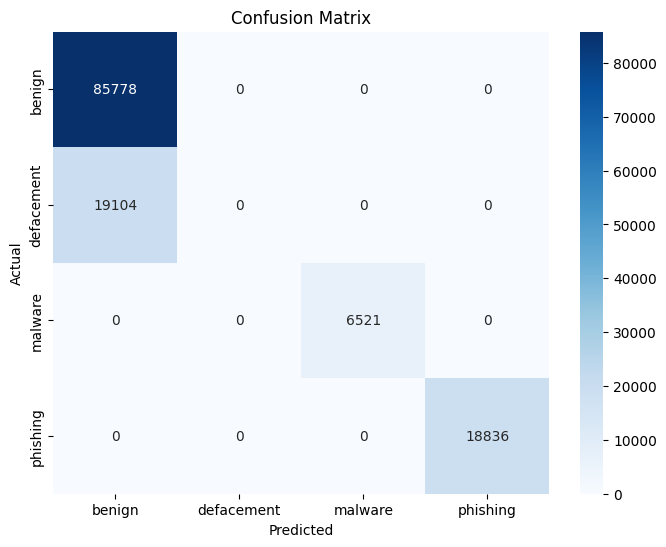

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Use K-Means clusters as features for KNN
X_with_clusters = df[['malware_encoded', 'phishing_encoded', 'cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Instantiate K-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)

# Predict using the trained KNN classifier
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the KNN classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Classifier Accuracy:", accuracy_knn)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**K-Means with SVM**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SVM Classifier Accuracy: 0.8533158270564116


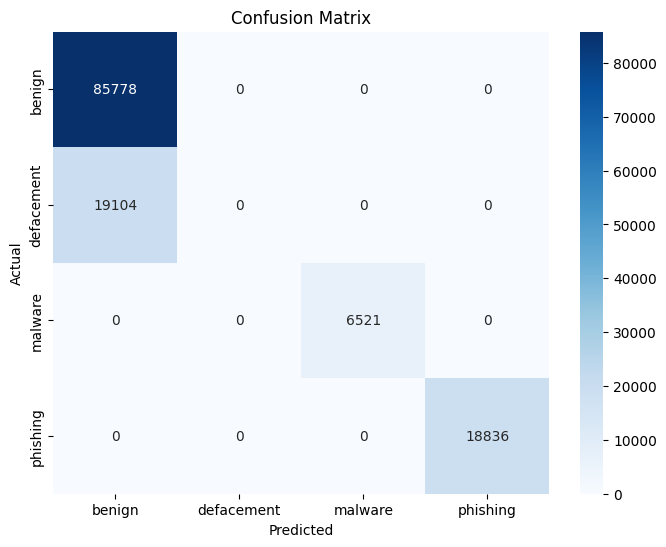

In [ ]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Specify the number of clusters (adjust as needed)
df['cluster'] = kmeans.fit_predict(X)

# Use K-Means clusters as features
X_with_clusters = df[['malware_encoded', 'phishing_encoded', 'cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Instantiate Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict using the trained SVM classifier
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the SVM classifier
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Classifier Accuracy:", accuracy_svm)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**K-Means with SVM with hyperperparameter**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SVM Classifier Accuracy: 0.8533158270564116


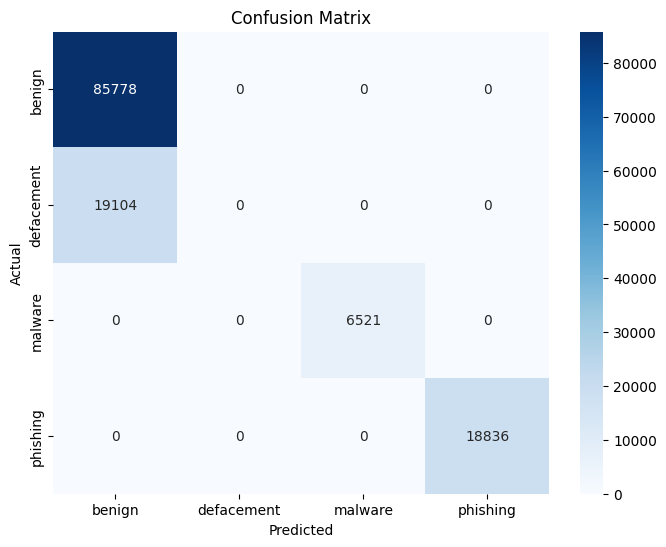

In [ ]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Use K-Means clusters as features
X_with_clusters = df[['malware_encoded', 'phishing_encoded', 'cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Instantiate Support Vector Machine (SVM) classifier with hyperparameters
svm_classifier = SVC(kernel='linear', C=1.0, gamma='scale')
# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict using the trained SVM classifier
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the SVM classifier
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Classifier Accuracy:", accuracy_svm)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


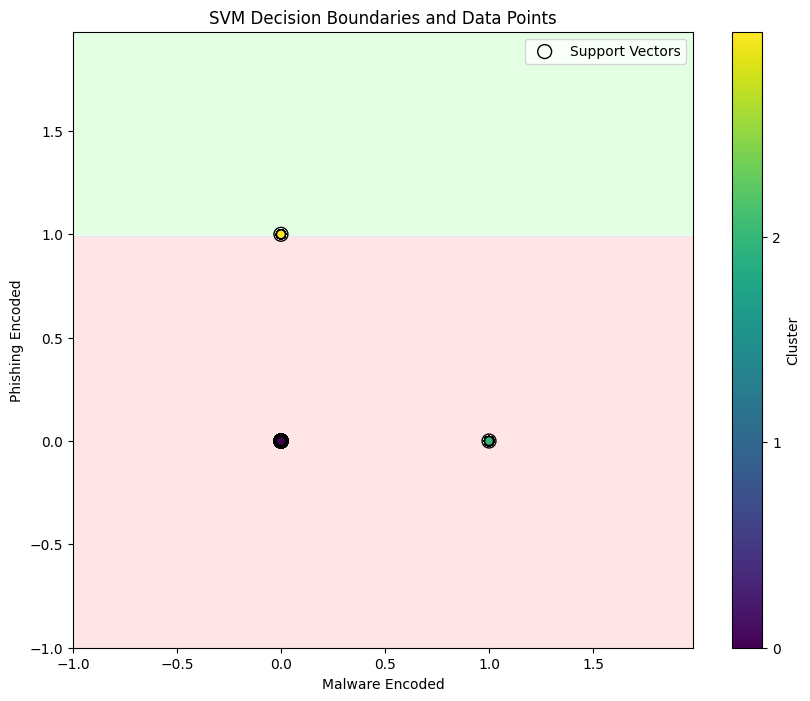

In [ ]:
from matplotlib.colors import ListedColormap

# Create a meshgrid for plotting decision boundaries
h = 0.02  # step size in the mesh
x_min, x_max = X_with_clusters.iloc[:, 0].min() - 1, X_with_clusters.iloc[:, 0].max() + 1
y_min, y_max = X_with_clusters.iloc[:, 1].min() - 1, X_with_clusters.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain predictions on the meshgrid
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])

# Reshape the predictions to match the meshgrid shape
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 8))
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)

# Scatter plot of data points
scatter = plt.scatter(X_with_clusters.iloc[:, 0], X_with_clusters.iloc[:, 1], c=y, cmap='viridis', edgecolors='k', s=40)  # Use a valid colormap like 'viridis'
plt.colorbar(scatter, ticks=[0, 1, 2], label='Cluster')

# Mark support vectors
plt.scatter(svm_classifier.support_vectors_[:, 0], svm_classifier.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')

plt.xlabel('Malware Encoded')
plt.ylabel('Phishing Encoded')
plt.title('SVM Decision Boundaries and Data Points')
plt.legend()
plt.show()


**Kmeans with KNN with Hyperparameter**


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
<ipython-input-23-9f375dbd0f4c>:63: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test['malware_encoded'], X_test['phishing_encoded'], c=y_test, edgecolors='k', marker='x', s=100, label='Test Set')


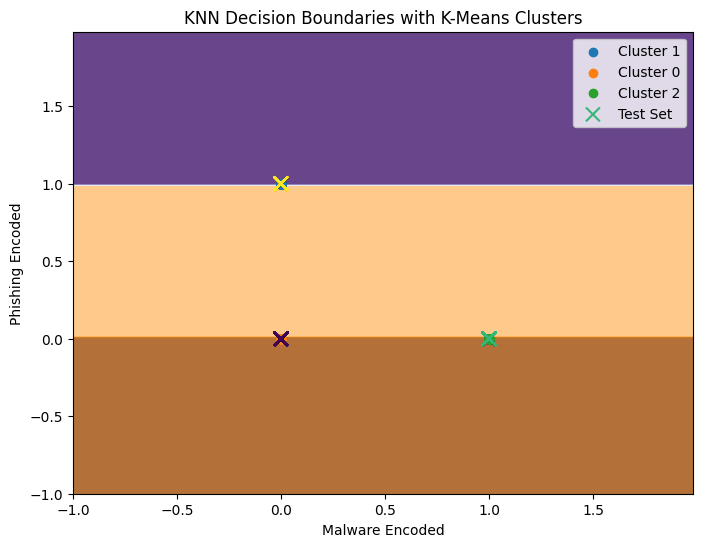

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Use K-Means clusters as features for KNN
X_with_clusters = df[['malware_encoded', 'phishing_encoded', 'cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Specify hyperparameters for KNN
n_neighbors = 5  # You can try different values
weights = 'distance'  # You can try 'uniform' or other values

# Instantiate K-Nearest Neighbors (KNN) classifier with specified hyperparameters
knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

# Train the KNN classifier
knn_classifier.fit(X_train[['malware_encoded', 'phishing_encoded', 'cluster']], y_train)

# Create a mesh grid
h = .02  # Step size in the mesh
x_min, x_max = X_with_clusters['malware_encoded'].min() - 1, X_with_clusters['malware_encoded'].max() + 1
y_min, y_max = X_with_clusters['phishing_encoded'].min() - 1, X_with_clusters['phishing_encoded'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class for each point in the mesh grid
Z = knn_classifier.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])

# Reshape the result to the mesh grid shape
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.PuOr, alpha=0.8)

# Scatter plot for each cluster
for cluster_label in df['cluster'].unique():
    cluster_points = X_with_clusters[df['cluster'] == cluster_label]
    plt.scatter(cluster_points['malware_encoded'], cluster_points['phishing_encoded'], label=f'Cluster {cluster_label}')

# Scatter plot for testing set with predictions
plt.scatter(X_test['malware_encoded'], X_test['phishing_encoded'], c=y_test, edgecolors='k', marker='x', s=100, label='Test Set')

plt.xlabel('Malware Encoded')
plt.ylabel('Phishing Encoded')
plt.title('KNN Decision Boundaries with K-Means Clusters')
plt.legend()

plt.show()
